In [26]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [27]:
# Определяем гиперпараметры модели
EPOCHS_NUM = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.0001

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Считываем тренировочные данные
X = np.load('/content/drive/MyDrive/Colab Notebooks/SOURCE/images.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/SOURCE/labels.npy')

# Преобразовываем данные в формат (48, 48, 3)
X = X.reshape(-1, 48, 48, 3) # Добавляем канал (3 для цветного RGB изображения)

# Разделяем данные на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

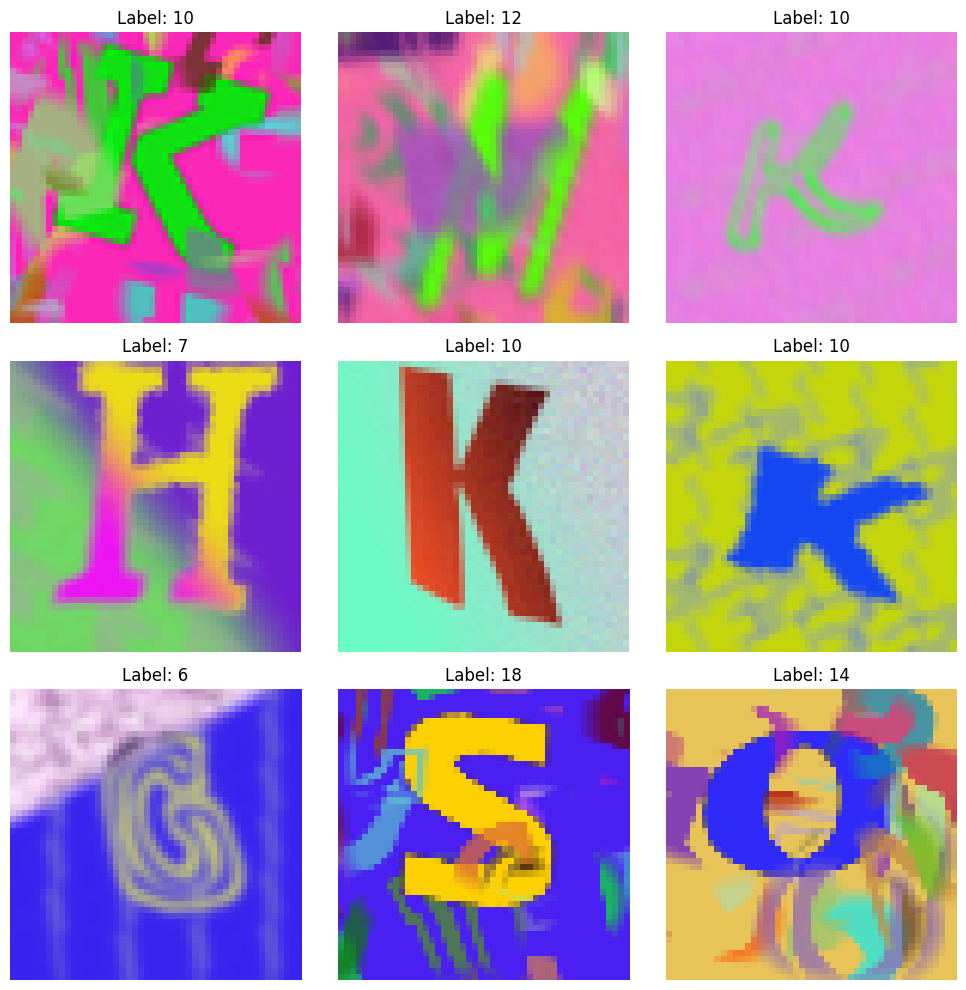

In [30]:
# Выводим на экран изображения
num_images = 9  # Количество изображений в сетке
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
# Считываем тестовые данные
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/SOURCE/images_sub.npy')

# Преобразовываем данные в формат (48, 48, 3)
X_test = X_test.reshape(-1, 48, 48, 3) # Добавляем канал (3 для цветного RGB изображения)

In [32]:
"""""
Реализация классификатора на основе сверточной нейронной сети (CNN). Эта модель предназначена для задачи классификации, в которой на выходе 26 классов.
Использована кросс-энтропийная функция потерь
"""""

class LightningClassifier(pl.LightningModule):
    # Определяем архитектуру модели
    def __init__(self, lr_rate):
        super().__init__()
        self.save_hyperparameters()

        # Слой аугментации
        # self.augmentations = T.Compose([
        #     T.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
        #     T.RandomRotation(degrees=15),  # Случайное вращение на 15 градусов
        #     T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)  # Изменение яркости, контраста и насыщенности
        # ])

        # Сверточные слои
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 64x24x24

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Output: 256x12x12

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Полносвязанные слои
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 6 * 6, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 26)
        )

        self.lr_rate = lr_rate
        self.train_losses = []
        self.val_losses = []
        self.train_epoch_losses = []
        self.val_epoch_losses = []

    # Определяем прямой проход
    def forward(self, x):
        # if self.training:
        #     x = self.augmentations(x)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

    # Определяем шаг обучения
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        self.train_losses.append(loss.item())
        return loss

    # Определяем шаг валидации
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss)
        self.val_losses.append(loss.item())
        return loss

    # Определяем шаг тестирования
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('test_loss', loss)
        return loss

    # Определяем оптимизатор
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr_rate)
        return optimizer

    # Расчитываем потери по окончании эпохи тренировки
    def on_train_epoch_start(self):
        self.train_losses = []

    def on_train_epoch_end(self):
        avg_train_loss = sum(self.train_losses) / len(self.train_losses)
        self.train_epoch_losses.append(avg_train_loss)
        self.log('avg_train_loss', avg_train_loss)

    # Расчитываем потери по окончании эпохи валидации
    def on_validation_epoch_start(self):
        self.val_losses = []

    def on_validation_epoch_end(self):
        avg_val_loss = sum(self.val_losses) / len(self.val_losses)
        self.val_epoch_losses.append(avg_val_loss)
        self.log('avg_val_loss', avg_val_loss)

In [33]:
# Преобразовываем датасет в тензоры и передаем количество каналов во второй элемент
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

In [34]:
# Определяем загрузчики данных
train = TensorDataset(X_train_tensor, y_train_tensor)
val = TensorDataset(X_val_tensor, y_val_tensor)
test = TensorDataset(X_test_tensor)

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE)
test_loader = DataLoader(test, batch_size=BATCH_SIZE)

In [35]:
# Определяем точку останова и сохранение чекпойнтов
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=5, verbose=False, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='Checkpoints', filename='best_model', save_top_k=1, mode='min')

In [36]:
# Инициализируем модель
model = LightningClassifier(lr_rate=LEARNING_RATE)

# Определяем гиперпараметры обучения
progress_bar = TQDMProgressBar(refresh_rate=1)
trainer = pl.Trainer(max_epochs=EPOCHS_NUM,
                     callbacks=[early_stop_callback, checkpoint_callback, progress_bar],
                     accelerator='gpu' if torch.cuda.is_available() else 'cpu')

# Обучаем модель
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params | Mode 
---------------------------------------------------
0 | conv_layers | Sequential | 3.9 M  | train
1 | fc_layers   | Sequential | 19.5 M | train
---------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
93.866    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

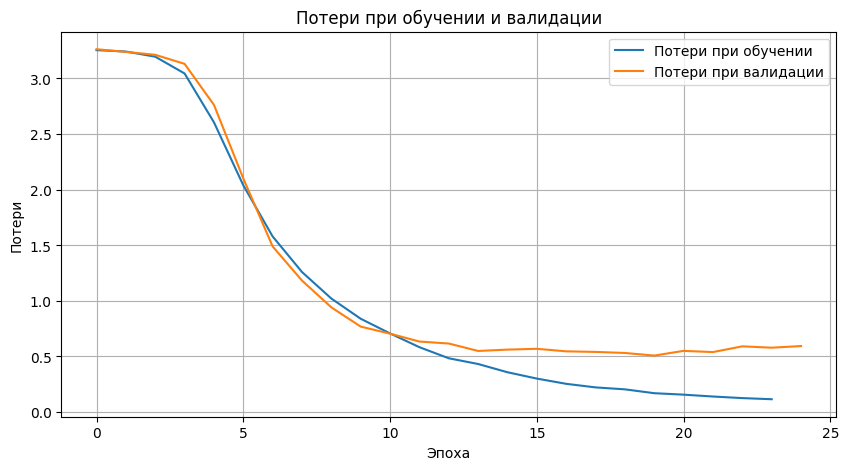

In [37]:
# Визуализируем потери при обучении и валидации в разрезе эпох
plt.figure(figsize=(10, 5))
plt.plot(model.train_epoch_losses, label='Потери при обучении')
plt.plot(model.val_epoch_losses, label='Потери при валидации')
plt.title('Потери при обучении и валидации')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Отбираем лучшую модель с минимальным значением функции потерь на валидационном сете
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model_path = checkpoint_callback.best_model_path
best_model = LightningClassifier.load_from_checkpoint(best_model_path)
best_model.to(device)
best_model.eval()

# Создаем список для хранения предсказаний
predictions = []

# Отключаем вычисление градиентов
with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        outputs = best_model(x)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [39]:
# Создаем DataFrame с Id и Category
results_df = pd.DataFrame({
    'Id': range(len(predictions)),
    'Category': predictions
})

# Сохраняем результаты в CSV
output_file = 'sample_submission.csv'
results_df.to_csv(output_file, sep=',', index=False)

print(f'Предсказания успешно сохранены в файл: {output_file}')

Предсказания успешно сохранены в файл: sample_submission.csv
